# 0.0 Mina Goranovic, Marija Brkic -> Information Retrieval Project -> Task 1  
The code for Task 2 was way to big so submit in the ecampus, so it can be found in our git repository: https://github.com/marija-brkic/Patent-Match-Prediction-2024-2025.git

## 1.0 Imports - !pip install <package_name> if necessary

In [2]:
import pandas as pd
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm


In [4]:
import os
os.environ["USE_TF"] = "0"
nltk.download('stopwords')
nltk.download('wordnet')  # For lemmatization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marij\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marij\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 0.1 Helper Functions

In [6]:
def load_json_data(file_path):
    with open(file_path, "r") as file:
        contents = json.load(file)
    return contents


def create_tfidf_matrix(citing_dataset, nonciting_dataset, vectorizer=TfidfVectorizer()):
    """
    Creates TF-IDF matrix for the given citing and non-citing datasets based on the specified text column.

    Parameters:
    citing_dataset (json)): DataFrame containing citing patents.
    nonciting_dataset (json): DataFrame containing non-citing patents.
    vectorizer (TfidfVectorizer, optional): TfidfVectorizer object for vectorizing text data.
                                             Defaults to TfidfVectorizer().

    Returns:
    tuple: A tuple containing TF-IDF matrices for citing and non-citing patents respectively.
           (tfidf_matrix_citing, tfidf_matrix_nonciting)
    """
    all_text = [patent['text'] for patent in citing_dataset + nonciting_dataset]

    # Vectorizing descriptions
    print("Vectorizing descriptions...")
    tfidf_matrix = vectorizer.fit_transform(tqdm(all_text, desc="TF-IDF"))

    # Since we're interested in similarities between citing and cited patents,
    # we need to split the TF-IDF matrix back into two parts
    split_index = len(citing_dataset)
    tfidf_matrix_citing = tfidf_matrix[:split_index]
    tfidf_matrix_nonciting = tfidf_matrix[split_index:]

    # Size of vocabulary
    print("Size of vocabulary:", len(vectorizer.vocabulary_))

    return tfidf_matrix_citing, tfidf_matrix_nonciting



def get_mapping_dict(mapping_df):
    """
    Creates dictionary of citing ids to non-citing id based on given dataframe (which is based on providedjson)

    Parameters:
    mapping_df (DataFrame): DataFrame containing mapping between citing and cited patents
    Returns:
    dict: dictionary of unique citing patent ids to list of cited patent ids
    """
    mapping_dict = {}

    for _, row in mapping_df.iterrows():
        key = row[0]  # Value from column 0
        value = row[2]  # Value from column 2
        if key in mapping_dict:
            mapping_dict[key].append(value)
        else:
            mapping_dict[key] = [value]

    return mapping_dict

def create_corpus(corpus, text_type): #OVO NAM TREBA SASVIM SIGURNO
    """
    Extracts text data from a corpus based on the specified text type.

    Parameters:
    corpus (list): List of dictionaries representing patent documents.
    text_type (str): Type of text to extract ('title', 'abstract', 'claim1', 'claims', 'description', 'fulltext').

    Returns:
    list: List of dictionaries with 'id' and 'text' keys representing each document in the corpus.
    """

    app_ids = [doc['Application_Number'] + doc['Application_Category'] for doc in corpus]

    cnt = 0 # count the number of documents without text
    texts = []  # list of texts
    ids_to_remove = []  # list of ids of documents without text, to remove them from the corpus

    if text_type == 'title':
        for doc in corpus:
            try:
                texts.append(doc['Content']['title'])
            except: # if the document does not have a title
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without title: {cnt}")

    elif text_type == 'abstract':
        for doc in corpus:
            try:
                texts.append(doc['Content']['pa01'])
            except: # if the document does not have an abstract
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without abstract: {cnt}")

    elif text_type == 'claim1':
        for doc in corpus:
            try:
                texts.append(doc['Content']['c-en-0001'])
            except: # if the document does not have claim 1
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
        print(f"Number of documents without claim 1: {cnt}")

    elif text_type == 'claims':
        # all the values with the key starting with 'c-en-', each element in the final list is a list of claims
        for doc in corpus:
            doc_claims = []
            for key in doc['Content'].keys():
                if key.startswith('c-en-'):
                    doc_claims.append(doc['Content'][key])
            if len(doc_claims) == 0:    # if the document does not have any claims
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_claims)
                texts.append(doc_text_string)
        print(f"Number of documents without claims: {cnt}")

    elif text_type == 'description':
        # all the values with the key starting with 'p'
        for doc in corpus:
            doc_text = []
            for key in doc['Content'].keys():
                if key.startswith('p'):
                    doc_text.append(doc['Content'][key])
            if len(doc_text) == 0:  # if the document does not have any description
                ids_to_remove.append(doc['Application_Number']+doc['Application_Category'])
                cnt += 1
            else:
                doc_text_string = ' '.join(doc_text)
                texts.append(doc_text_string)
        print(f"Number of documents without description: {cnt}")

    elif text_type == 'fulltext':
        for doc in corpus:
            doc_text = list(doc['Content'].values())
            doc_text_string = ' '.join(doc_text)
            texts.append(doc_text_string)
        if cnt > 0:
            print(f"Number of documents without any text: {cnt}")

    else:
        raise ValueError("Invalid text type")

    if len(ids_to_remove) > 0:
        print(f"Removing {len(ids_to_remove)} documents without required text")
        for id_ in ids_to_remove[::-1]:
            idx = app_ids.index(id_)
            del app_ids[idx]

    # Create a list of dictionaries with app_ids and texts
    corpus_data = [{'id': app_id, 'text': text} for app_id, text in zip(app_ids, texts)]

    return corpus_data


def get_true_and_predicted(citing_to_cited_dict, recommendations_dict):
    """
    Get the true and predicted labels for the metrics calculation.

    Parameters:
    citing_to_cited_dict : dict of str : list of str
        Mapping between citing patents and the list of their cited patents
    recommendations_dict : dict of str : list of str
        Mapping between citing patents and the sorted list of recommended patents

    Returns:
    list of list
        True relevant items for each recommendation list.
    list of list
        Predicted recommended items for each recommendation list.
    int
        Number of patents not in the citation mapping
    """
    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []
    not_in_citation_mapping = 0

    # Iterate over the items in both dictionaries
    for citing_id in recommendations_dict.keys():
        # Check if the citing_id is present in both dictionaries
        if citing_id in citing_to_cited_dict:
            # If yes, append the recommended items from both dictionaries to the respective lists
            true_labels.append(citing_to_cited_dict[citing_id])
            predicted_labels.append(recommendations_dict[citing_id])
        else:
            not_in_citation_mapping += 1

    return true_labels, predicted_labels, not_in_citation_mapping



def mean_recall_at_k(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Recall@k for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Recall@k value.
    """
    recalls_at_k = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Recall@k for each recommendation list
        true_set = set(true)
        k = min(k, len(pred))
        relevant_count = sum(1 for item in pred[:k] if item in true_set)
        recalls_at_k.append(relevant_count / len(true_set))

    # Calculate the mean Recall@k
    mean_recall = sum(recalls_at_k) / len(recalls_at_k)

    return mean_recall

def mean_inv_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean inverse rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean inverse rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the inverse rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = 1 / (pred.index(item) + 1)
            except ValueError:
                rank = 0  # If item not found, assign 0
            ranks.append(rank)

        # Calculate the mean inverse rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean inverse ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks


def mean_ranking(true_labels, predicted_labels):
    """
    Calculate the mean of lists of the mean rank of true relevant items
    in the lists of sorted recommended items.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.

    Returns:
    float
        Mean of lists of the mean rank of true relevant items.
    """
    mean_ranks = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate the rank of true relevant items
        # in the recommendation list
        ranks = []
        for item in true:
            try:
                rank = pred.index(item) + 1
            except ValueError:
                rank = len(pred)  # If item not found, assign the length of the list
            ranks.append(rank)

        # Calculate the mean rank of true relevant items
        # in the recommendation list
        mean_rank = sum(ranks) / len(ranks)
        mean_ranks.append(mean_rank)

    # Calculate the mean of the mean ranks across all recommendation lists
    mean_of_mean_ranks = sum(mean_ranks) / len(mean_ranks)

    return mean_of_mean_ranks



def mean_average_precision(true_labels, predicted_labels, k=10):
    """
    Calculate the mean Average Precision for a list of recommendations.

    Parameters:
    true_labels : list of list
        True relevant items for each recommendation list.
    predicted_labels : list of list
        Predicted recommended items for each recommendation list.
    k : int
        Number of recommendations to consider.

    Returns:
    float
        Mean Average Precision value.
    """
    average_precisions = []

    for true, pred in zip(true_labels, predicted_labels):
        # Calculate Average Precision for each recommendation list
        true_set = set(true)
        precision_at_k = []
        relevant_count = 0
        for i, item in enumerate(pred[:k]):
            if item in true_set:
                relevant_count += 1
                precision_at_k.append(relevant_count / (i + 1))
        average_precision = sum(precision_at_k) / len(true_set)
        average_precisions.append(average_precision)

    # Calculate the mean Average Precision
    mean_average_precision = sum(average_precisions) / len(average_precisions)

    return mean_average_precision

def top_k_ranks(citing, cited, cosine_similarities, k=10):
    # Create a dictionary to store the top k ranks for each citing patent
    top_k_ranks = {}
    for i, content_id in enumerate(citing):
        top_k_ranks[content_id['id']] = [cited[j]['id'] for j in np.argsort(cosine_similarities[i])[::-1][:k]]
    return top_k_ranks


# 1.0 Load Datasets

In [8]:
json_citing_train = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TRAIN.json")
json_citing_test = load_json_data("./datasets/Content_JSONs/Citing_2020_Cleaned_Content_12k/Citing_Train_Test/citing_TEST.json")

json_nonciting = load_json_data("./datasets/Content_JSONs/Cited_2020_Uncited_2010-2019_Cleaned_Content_22k/CLEANED_CONTENT_DATASET_cited_patents_by_2020_uncited_2010-2019.json")
json_citing_to_cited = load_json_data("./datasets/Citation_JSONs/Citation_Train.json") # Citing ids are unique

In [10]:
citing_dataset_df = pd.DataFrame(json_citing_train)

nonciting_dataset_df = pd.DataFrame(json_nonciting)
mapping_dataset_df = pd.DataFrame(json_citing_to_cited)

In [12]:
citing_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,3650293,2020-05-13,A1,{'title': 'DEVICE FOR CONTROLLING THE BRAKING ...
1,3694265,2020-08-12,A1,{'title': 'TIME DIVISION MULTIPLEXING OF SYNCH...
2,3623522,2020-03-18,A1,{'title': 'LAUNDRY MACHINE AND CONTROL METHOD ...
3,3611147,2020-02-19,A1,{'title': 'CHEMICAL AND TOPOLOGICAL SURFACE MO...
4,3640454,2020-04-22,A1,"{'title': 'FUEL METERING SYSTEM', 'pa01': 'The..."
...,...,...,...,...
6826,3741587,2020-11-25,A1,{'title': 'AUTO-LOCATION USING TIRE MOUNTED SY...
6827,3693248,2020-08-12,A1,{'title': 'HOLE COVER AND STEERING SYSTEM INCL...
6828,3628962,2020-04-01,A1,{'title': 'SYSTEM AND METHOD FOR MEASURING CLE...
6829,3620899,2020-03-11,A1,{'title': 'TOUCH SCREEN AND DISPLAY APPARATUS'...


In [14]:
nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',..."
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u..."
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...
...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en..."
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...


In [15]:
mapping_dataset_df #this means patents '0' are rejected because their clames '1' have been mentioned in patents '2' in paragraphs '3' and the decision is '3'

,0,1,2,3,4
0,3712070A1,[c-en-0004],3354576A1,"[p0024, p0027, c-en-0012, c-en-0013]",A
1,3675165A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3336831A2,"[p0045, p0046, p0047, p0048, p0049, p0050, p00...",A
2,3599626A1,"[c-en-0002, c-en-0003, c-en-0004, c-en-0005, c...",2453448A1,"[p0029, p0030]",A
3,3705201A1,"[c-en-0001, c-en-0002, c-en-0004, c-en-0006, c...",2468433A2,"[p0011, p0012, p0013, p0014, p0015, p0016, p00...",X
4,3628210A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3369366A1,[pa01],A
...,...,...,...,...,...
8589,3623977A1,"[c-en-0008, c-en-0009, c-en-0010, c-en-0011, c...",2518981A1,"[p0021, p0022, p0023, p0024, p0025, p0026, p00...",A
8590,3721843A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3213727A1,"[p0015, p0016, p0017, p0018, p0019, p0020, p00...",X
8591,3708263A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",3217171A1,"[pa01, p0010, p0014, p0003, p0009, p0016]",A
8592,3588557A1,"[c-en-0001, c-en-0002, c-en-0003, c-en-0004, c...",2988328A1,"[p0047, p0012]",A


In [121]:
mapping_dict = get_mapping_dict(mapping_dataset_df)
#mapping_dict

In [14]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

## 1.1 Take a look at the content

In [30]:
nonciting_dataset_df.loc[0].Content #dictionary basicaly


{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',
 'c-en-0001': 'A vehicle support assembly, comprising: first and second tilting wheels (421A, 421B; 16, 16) disposed respectively at different lateral positions with respect to a longitudinal axis; a tilt-mechanism (431; 17) configured for supportively associating a vehicle body (402) from the tilting wheels (421A, 421B; 16, 16) to enable the vehicle body (402) to tilt substantially through a first tilt range with respect to a surface (428) on which the tilting wheels (421A, 421B; 16, 16) are disposed; a tilt-limiter (450, 550, 650) operably associated with the tilt-mechanism (431) to restrict the tilting of the vehicle body (402) to less than the first tilt range, and releasable to allow the tilting through the first tilt range; characterised in that the vehicle support assembly further comprises : an inclination sensor configured to sense an inclination of the vehicle (130, 430) with respect to the vertical at least when the vehicle is a

We can notice that this document contains a title, claims and a descriprion devided into paragraphs. This document does not have an abstract. We already kno that the first claim could be the most important one and the one that explaines in short the whole patent, or the most important idea of it. For us it could make sense to observe:  
    - the relationship between all claims of citing patents and description of cited patents: because claims could 'sumarize' what is the idea of the whole document, and if we look at the maped dataset, we can see that most patents are cited form paragraphs to different claims, so this might be the best solution
    - the relationship between first claims of citing patents and all clims of cited patents: because other claims are usually somehow connected to the first claim, or they directly depend on it   
    - the relationship between first claims of citing patents and first claims of cited patents: because the similarity between first claims is a very clear sign of existing patent, however we can expect that this will not happen all that often.
    

As for the models, we thought that sparse embeddings might not be the best approach in this case. They rely on exact word matching, which can be misleading, and based on your proposed results, they do not perform particularly well. Therefore, we decided to try a few dense embedding strategies, such as Doc2Vec and the BERT model, which will be explained later.

## 1.2 Create a column with the Title

Note for lateR: Try all text content by uncommenting the below

In [19]:
#import ast
#nonciting_dataset_df['all_content'] = nonciting_dataset_df['Content'].apply(ast.literal_eval)

In [43]:
def extract_title(dictionary):
    return dictionary.get('title', None)  # Return None if 'title' key is not present

nonciting_dataset_df['Title'] = nonciting_dataset_df['Content'].apply(extract_title)
citing_dataset_df['Title'] = citing_dataset_df['Content'].apply(extract_title)

nonciting_dataset_df

,Application_Number,Application_Date,Application_Category,Content,Title
0,2019772,2013-08-28,B1,"{'title': 'VEHICLE WITH LOCKABLE TILT SYSTEM',...",VEHICLE WITH LOCKABLE TILT SYSTEM
1,2136094,2013-05-22,B1,"{'title': 'UNIVERSAL JOINT', 'c-en-0001': 'A u...",UNIVERSAL JOINT
2,2340701,2011-07-06,A2,"{'title': 'Apparatus, method and computer prog...","Apparatus, method and computer program product..."
3,2338661,2011-06-29,A1,{'title': 'Method and apparatus for forming a ...,Method and apparatus for forming a rubber article
4,2339144,2011-06-29,A2,{'title': 'Heat exchanger mounting assembly in...,Heat exchanger mounting assembly in a gas turbine
...,...,...,...,...,...
16832,1995910,2012-07-11,B1,"{'title': 'Synchronization of a split audio, v...","Synchronization of a split audio, video, or ot..."
16833,1997557,2012-02-08,B1,{'title': 'Fluid handling unit and fluid handl...,Fluid handling unit and fluid handling apparat...
16834,1992846,2012-04-04,B1,"{'title': 'Oil pump system for vehicle', 'c-en...",Oil pump system for vehicle
16835,1981195,2012-01-11,B1,{'title': 'Apparatus for construction of quasi...,Apparatus for construction of quasi orthogonal...


## 1.3 Number of CITED patents per citing patent

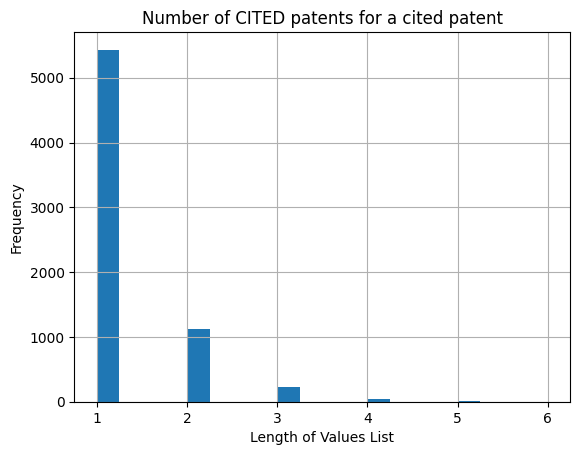

In [45]:
list_lengths = [len(values) for values in mapping_dict.values()]

plt.hist(list_lengths, bins=20)
plt.xlabel('Length of Values List')
plt.ylabel('Frequency')
plt.title('Number of CITED patents for a cited patent')
plt.grid(True)
plt.show()


Before getting into descriprions, we wanted to define some of the used evaluation metrics and their limitations.  
- Precision @ k:  
   $$precission = \frac{TP}{K_{predited}\_P}$$

  Precission calculates the percentage of well predicted relevant patents divided among K predicted relevant documents. The important thing that we have to keep in mind is that for each patent the maximum number of cited documents i 6, which is shown on the previous histogram. Since in one of the help functions, we are calculating the mean precission in the firs 10 predicted documents, for one document $\frac{TP}{10}$ could not be larger than 10, if the document has 10 cited documents and if all of them are in the first 10 prediced documents. Next, after averaging that on all documents, we have to keep in mind not to expect this value to go over approximately 50%.

- Recall @ k:  
   $$recall = \frac{TP}{P}$$

  Recall at k represents the percentage of well predicted relevant documents out of real relevant documents, but in k predictions. This can go up to 100% if we are lucky.

- Mean ranking represents how well we ranked the well prediced documents.

  

# 2 Implementation

## 2.1 Doc2Vec 
### 2.1.1 Doc2Vec on claims for citing patents and description on cited patents  
First we have to explain how does Doc2Vec work and why did we chose to work with it. Document to vector embedding works very similarly to word to vector algorithmsm that are skip-gram and CBOW. Document to vectore captures paragraph or document embedding in such way that similar documents are close in vector space. However, besides regular word embeddings, it includes an ID of paragraph(or in our case a word) which allows us to observe the sense of the document as whole, and not just separate words.  
Doc2Vec uses two algorithms called Distributed Memory(inspired by CBOW) and Distributed Bag of Words(inspired by skip-gram):
![DM and DBoW](img.png)
As it can be seen on an image, these algorithms work very similarly to Word2Vec algorithmsm except they have an additional feature. In DM, ID of the paragraph/word is used as another output next to context words, while in DBoW, an ID is used as an input instead of target word, in order to predict context words. In all our next code wq will use vector size 300, because smaller one might not capture enough data, window size 5, and train the network for 30 epochs. For tokenizing, we used simple_preprocess(), which removes numbers and interpunction and lowercases and returns tokens of the length between 2 and 15[https://tedboy.github.io/nlps/_modules/gensim/utils.html#simple_preprocess].  
Finally after data embeding we can find cosine similarity and based on that find the most relevant patents.

In [56]:
claims_citing_train = create_corpus(json_citing_train , 'claims')
claims_citing_test = create_corpus(json_citing_test , 'claims')

descriprion_nonciting = create_corpus(json_nonciting, 'description')
#claims_citing_train[:2]

Number of documents without claims: 0
Number of documents without claims: 0
Number of documents without description: 0


In [58]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

all_docs_d2v_cd = claims_citing_train + descriprion_nonciting

tagged_docs_d2v_cd = [
    TaggedDocument(words=simple_preprocess(doc['text']), tags=[doc['id']])
    for doc in all_docs_d2v_cd
] #gensim.utils.simple_preprocess() uzima samo slova min duzine 2 max duzine 15 

In [69]:
model_d2v_cd = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs = 30)

model_d2v_cd.build_vocab(tagged_docs_d2v_cd)

model_d2v_cd.train(tagged_docs_d2v_cd, total_examples=model_d2v_cd.corpus_count, epochs=model_d2v_cd.epochs)

In [81]:
vectors_by_id_d2v_cd = {doc['id']: model_d2v_cd.dv[doc['id']] for doc in claims_citing_train}
vectors_by_id_d2v_cd1 = {doc['id']: model_d2v_cd.dv[doc['id']] for doc in descriprion_nonciting}

In [83]:
vectors_by_id_list_d2v_cd = [vec.tolist() for vec in vectors_by_id_d2v_cd.values()]
vectors_by_id_list_d2v_cd1 = [vec.tolist() for vec in vectors_by_id_d2v_cd1.values()]

In [85]:
cosine_similarities_d2v_cd = linear_kernel(vectors_by_id_list_d2v_cd, vectors_by_id_list_d2v_cd1)
cosine_similarities_d2v_cd

array([[ 68.10290525,  55.84348628, -16.76568087, ..., 133.86160854,
         60.32533674,  74.04376177],
       [ 27.9201    ,  42.09617593,  38.36402711, ...,  64.90619179,
        232.25354515,  29.37063873],
       [-33.18729856,  84.55886282,  11.46876006, ..., 150.31974152,
        141.78140785, 107.92516859],
       ...,
       [ 61.80640173,  53.2705212 , 134.0250661 , ...,  33.91754578,
        140.14290247, 110.45794807],
       [ 92.52725148,  81.01167012,  75.05724031, ...,  77.97030897,
         11.5774164 ,  97.79234646],
       [ 37.92575272,  50.96859482,  78.37204844, ...,  37.13707959,
         85.59354877,  53.92051656]])

In [89]:
k = 100
top_k_rank_d2v_cd = top_k_ranks(claims_citing_train, descriprion_nonciting, cosine_similarities_d2v_cd, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank_d2v_cd)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_d2v_cd = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_d2v_cd = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_d2v_cd = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_d2v_cd = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_d2v_cd, 4))
print("Recall at 20:", round(recall_at_20_d2v_cd, 4))
print("Recall at 50:", round(recall_at_50_d2v_cd, 4))
print("Recall at 100:", round(recall_at_100_d2v_cd, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Recall at 10: 0.4793
Recall at 20: 0.5679
Recall at 50: 0.6848
Recall at 100: 0.7624
Mean ranking: 36.0658
Mean average precision: 0.2837
Number of patents measured: 6831
Number of patents not in the citation: 0


Comparison of the best matched prediced document and best matched cited document:

In [108]:
filtered_df = citing_dataset_df[
    (citing_dataset_df['Application_Number'] == '3650293') &
    (citing_dataset_df['Application_Category'] == 'A1')
]
filtered_df['Content'].iloc[0]['c-en-0001']

#nonciting_dataset_df[nonciting_dataset_df['Application_Number']==top_k_rank_d2v_cd['3650293A1'][0]].Content['p0001']

'Device (1) for controlling the braking of a trailer, comprising: - at least one control line (2) connectable to a source of a work fluid at a first pressure; - a braking line (3) connectable to the service braking system (4) of the trailer and communicating with said control line (2); - at least one additional line (5) connectable to a source of a work fluid at a second pressure; - at least one emergency line (6) connectable to said additional line (5) and connectable to the emergency and/or parking brake (7) of the trailer of the type of a hydraulically released spring brake; - at least one discharge line (8) of the work fluid communicating with a collection tank (9); - first valve means operable between a braking position, wherein said additional line (5) is isolated from said discharge line (8), and an emergency position, wherein said additional line (5) is communicating with said discharge line (8);'

In [127]:
filtered_df = nonciting_dataset_df[
    (nonciting_dataset_df['Application_Number'] == '3085590') &
    (nonciting_dataset_df['Application_Category'] == 'A1')
]
filtered_df['Content'].iloc[0]['p0001']

'The present invention relates to a device for controlling the braking of a trailer. It is known that in the case of a trailer towed by a prime mover their braking systems are operatively connected so that the braking of the prime mover actuated by the operator also causes the braking of the towed trailer.'

In [129]:
cited_id = mapping_dict['3650293A1'][0]
filtered_df = nonciting_dataset_df[
    (nonciting_dataset_df['Application_Number'] == cited_id[:-2]) &
    (nonciting_dataset_df['Application_Category'] == cited_id[-2:])
]
filtered_df['Content'].iloc[0]['p0001']

'The present invention relates to device for the towing vehicle-trailer connection. As is known, to date towing vehicles are connected to the relative trailer through a connection device comprising a male coupling associated with the towing vehicle and a relative female coupling associated with the trailer.'

Finally, we can see that the results are not bad. We got 76.24% of recall@100, and 28.37% of precision. Also the average rank of relevant data is 36.0658. These results are quite good, especially if we consider mean average precision. However, it would be good to look at the data and see the difference between predicted and actually relevant patents. The previous three cells show one of the citing patents (only the first claim) and two cited patents (their first paragraphs). We can notice a very interesting thing. Even though the prediction and ground truth are not the same document, we can notice that the structure of the first paragraphs is almost identical. The same words are used, the same phrasing, they both talk about trailers, however one of them is talking about the breaking system, and the other one is talking vehicle-trailer connection. It could be understood why these two documents would both be considered relevant for the topic, and how could be very close in the vector space. But probably the most interesting part is that the citing document is actually talking about the breaking system of a trailer, and not about trailer-vehicle connection, but it is using a lot of 'connection' word, so we can conslude that for the creation of a map dataset, some word matching algorithm was used, such as TF_IDF or BM25.  
This result is the best one vor Doc2Vec because we are using the whole descriprions and citations, which is also mostly cited, as shown in the mapping dataset.

### 2.1.2 Doc2Vec on first claim for citing patents and claims on cited patents

In [91]:
claim1_citing_train = create_corpus(json_citing_train , 'claim1')
claim1_citing_test = create_corpus(json_citing_test , 'claim1')

claims_nonciting = create_corpus(json_nonciting, 'claims')
#claims_citing_train[:2]
all_docs = claim1_citing_train + claims_nonciting
tagged_docs = [
    TaggedDocument(words=simple_preprocess(doc['text']), tags=[doc['id']])
    for doc in all_docs
]
model = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs = 30)

model.build_vocab(tagged_docs)

model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
vectors_by_id = {doc['id']: model.dv[doc['id']] for doc in claim1_citing_train}

vectors_by_id1 = {doc['id']: model.dv[doc['id']] for doc in claims_nonciting}
vectors_by_id_list = [vec.tolist() for vec in vectors_by_id.values()]
vectors_by_id_list1 = [vec.tolist() for vec in vectors_by_id1.values()]

cosine_similarities = linear_kernel(vectors_by_id_list, vectors_by_id_list1)
cosine_similarities

k = 100
top_k_rank = top_k_ranks(claim1_citing_train, claims_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_d2v_c1c = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_d2v_c1c = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_d2v_c1c = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_d2v_c1c = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_d2v_c1c, 4))
print("Recall at 20:", round(recall_at_20_d2v_c1c, 4))
print("Recall at 50:", round(recall_at_50_d2v_c1c, 4))
print("Recall at 100:", round(recall_at_100_d2v_c1c, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claims: 3
Removing 3 documents without required text
Recall at 10: 0.2439
Recall at 20: 0.3065
Recall at 50: 0.4152
Recall at 100: 0.4979
Mean ranking: 61.7052
Mean average precision: 0.1325
Number of patents measured: 6831
Number of patents not in the citation: 0


Afetr using only claim 1 for citing documents and all claims for cited documents, we can see that the results are much worse than in the previous case, which could be expected, for the reasons already mentioned.

### 2.1.3 Doc2Vec on first claim for citing patents and first claim on cited patents

In [92]:
claim1_citing_train = create_corpus(json_citing_train , 'claim1')
claim1_citing_test = create_corpus(json_citing_test , 'claim1')

claim1_nonciting = create_corpus(json_nonciting, 'claim1')
#claims_citing_train[:2]
all_docs = claim1_citing_train + claim1_nonciting
tagged_docs = [
    TaggedDocument(words=simple_preprocess(doc['text']), tags=[doc['id']])
    for doc in all_docs
]
model = Doc2Vec(vector_size=300, window=5, min_count=2, workers=4, epochs = 30)

model.build_vocab(tagged_docs)

model.train(tagged_docs, total_examples=model.corpus_count, epochs=model.epochs)
vectors_by_id = {doc['id']: model.dv[doc['id']] for doc in claim1_citing_train}

vectors_by_id1 = {doc['id']: model.dv[doc['id']] for doc in claim1_nonciting}
vectors_by_id_list = [vec.tolist() for vec in vectors_by_id.values()]
vectors_by_id_list1 = [vec.tolist() for vec in vectors_by_id1.values()]

cosine_similarities = linear_kernel(vectors_by_id_list, vectors_by_id_list1)
cosine_similarities

k = 100
top_k_rank = top_k_ranks(claim1_citing_train, claim1_nonciting, cosine_similarities, k=k)

# Calculate the metrics
true_labels, predicted_labels, not_in_citation_mapping = \
    get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10_d2v_c1c1 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20_d2v_c1c1 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50_d2v_c1c1 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100_d2v_c1c1 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10_d2v_c1c1, 4))
print("Recall at 20:", round(recall_at_20_d2v_c1c1, 4))
print("Recall at 50:", round(recall_at_50_d2v_c1c1, 4))
print("Recall at 100:", round(recall_at_100_d2v_c1c1, 4))


print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in the citation:", not_in_citation_mapping)

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claim 1: 3
Removing 3 documents without required text
Recall at 10: 0.0849
Recall at 20: 0.1206
Recall at 50: 0.1875
Recall at 100: 0.2514
Mean ranking: 82.723
Mean average precision: 0.0419
Number of patents measured: 6831
Number of patents not in the citation: 0


Afetr using only claim 1 for citing documents and claim 1 for cited documents, we can see that the results are even worse than in the before, which could be expected, for the reasons already mentioned.

## 2.2 BERT Encoder  
Now we also wanted to test another encoding method that is based on transformers. We used a Sentence Transformer BERT 'all-MiniLM-L6-v2' model from hugging face, and managed to improve our results.

### 2.2.1 BERT Encoder on claims for citing patents and description on cited patents

In [69]:
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoModel
import transformers
#VECTOR LENGTH IS 384

#this next part is because we had some huge problems with importing of transformers and this solves it
if not hasattr(transformers.modeling_utils, 'init_empty_weights'):
    from contextlib import contextmanager
    @contextmanager
    def init_empty_weights():
        yield
    transformers.modeling_utils.init_empty_weights = init_empty_weights

if not hasattr(transformers.modeling_utils, 'find_tied_parameters'):
    def find_tied_parameters(*args, **kwargs):
        return {}
    transformers.modeling_utils.find_tied_parameters = find_tied_parameters


try:
    model = SentenceTransformer(
        'all-MiniLM-L6-v2',
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_kwargs={
            'low_cpu_mem_usage': True,
            'tie_word_embeddings': False 
        }
    )
except Exception as e:
    print(f"First load attempt failed: {e}")
    model = SentenceTransformer(
        'all-MiniLM-L6-v2',
        device='cpu'
    )


#from here is our actual code
claims_citing_train = create_corpus(json_citing_train, 'claims')
claims_citing_test = create_corpus(json_citing_test, 'claims')
description_nonciting = create_corpus(json_nonciting, 'description')

texts_citing = [doc['text'] for doc in claims_citing_train]
texts_nonciting = [doc['text'] for doc in description_nonciting]

embeddings_citing = model.encode(texts_citing, convert_to_tensor=True)
embeddings_nonciting = model.encode(texts_nonciting, convert_to_tensor=True)

cosine_similarities = linear_kernel(embeddings_citing.tolist(), embeddings_nonciting.tolist())

k = 100
top_k_rank = top_k_ranks(claims_citing_train, descriprion_nonciting, cosine_similarities, k=k)

# Calculate metrics
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10, 4))
print("Recall at 20:", round(recall_at_20, 4))
print("Recall at 50:", round(recall_at_50, 4))
print("Recall at 100:", round(recall_at_100, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in citation:", not_in_citation_mapping)

First load attempt failed: [Errno 2] No such file or directory: 'sentence-transformers/all-MiniLM-L6-v2\\sentence_xlnet_config.json'
Number of documents without claims: 0
Number of documents without claims: 0
Number of documents without description: 0
Recall at 10: 0.5214
Recall at 20: 0.6158
Recall at 50: 0.7378
Recall at 100: 0.8104
Mean ranking: 31.2318
Mean average precision: 0.3208
Number of patents measured: 6831
Number of patents not in citation: 0


First we also tried all the claims for citing documents, and the description for cited documents, and the results are improved than with Doc2Vec. BERT transformesrs also include paragraph IDs in their training in order to preserve the sense of the text, and the reason why this is better then Doc2Vec could be because it is a larger architecture. This was finally our best result, and we used it on test patents as well.

### 2.2.1 BERT Encoder on claims for citing patents and description on cited patents

In [73]:
#from here is our actual code
claim1_citing_train = create_corpus(json_citing_train, 'claim1')
claim1_citing_test = create_corpus(json_citing_test, 'claim1')
clames_nonciting = create_corpus(json_nonciting, 'claims')

texts_citing = [doc['text'] for doc in claim1_citing_train]
texts_nonciting = [doc['text'] for doc in clames_nonciting]

embeddings_citing = model.encode(texts_citing, convert_to_tensor=True)
embeddings_nonciting = model.encode(texts_nonciting, convert_to_tensor=True)

cosine_similarities = linear_kernel(embeddings_citing.tolist(), embeddings_nonciting.tolist())

k = 100
top_k_rank = top_k_ranks(claim1_citing_train, clames_nonciting, cosine_similarities, k=k)

# Calculate metrics
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10, 4))
print("Recall at 20:", round(recall_at_20, 4))
print("Recall at 50:", round(recall_at_50, 4))
print("Recall at 100:", round(recall_at_100, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in citation:", not_in_citation_mapping)

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claims: 3
Removing 3 documents without required text
Recall at 10: 0.493
Recall at 20: 0.5847
Recall at 50: 0.6995
Recall at 100: 0.7747
Mean ranking: 34.5613
Mean average precision: 0.3053
Number of patents measured: 6831
Number of patents not in citation: 0


The previous result is made on first claim of citing documents and all of the claims of cited documents. This result is worse than the previous one, which is expected, but it is also better than the best Doc2Vec.

### 2.2.1 BERT Encoder on claims for citing patents and description on cited patents

In [75]:
#from here is our actual code
claim1_citing_train = create_corpus(json_citing_train, 'claim1')
claim1_citing_test = create_corpus(json_citing_test, 'claim1')
clame1_nonciting = create_corpus(json_nonciting, 'claim1')

texts_citing = [doc['text'] for doc in claim1_citing_train]
texts_nonciting = [doc['text'] for doc in clame1_nonciting]

embeddings_citing = model.encode(texts_citing, convert_to_tensor=True)
embeddings_nonciting = model.encode(texts_nonciting, convert_to_tensor=True)

cosine_similarities = linear_kernel(embeddings_citing.tolist(), embeddings_nonciting.tolist())

k = 100
top_k_rank = top_k_ranks(claim1_citing_train, clame1_nonciting, cosine_similarities, k=k)

# Calculate metrics
true_labels, predicted_labels, not_in_citation_mapping = get_true_and_predicted(mapping_dict, top_k_rank)
mean_rank = mean_ranking(true_labels, predicted_labels)
mean_average_precision_val = mean_average_precision(true_labels, predicted_labels)
recall_at_10 = mean_recall_at_k(true_labels, predicted_labels, k=10)
recall_at_20 = mean_recall_at_k(true_labels, predicted_labels, k=20)
recall_at_50 = mean_recall_at_k(true_labels, predicted_labels, k=50)
recall_at_100 = mean_recall_at_k(true_labels, predicted_labels, k=100)

print("Recall at 10:", round(recall_at_10, 4))
print("Recall at 20:", round(recall_at_20, 4))
print("Recall at 50:", round(recall_at_50, 4))
print("Recall at 100:", round(recall_at_100, 4))
print("Mean ranking:", round(mean_rank, 4))
print("Mean average precision:", round(mean_average_precision_val, 4))
print("Number of patents measured:", len(predicted_labels))
print("Number of patents not in citation:", not_in_citation_mapping)

Number of documents without claim 1: 0
Number of documents without claim 1: 0
Number of documents without claim 1: 3
Removing 3 documents without required text
Recall at 10: 0.4763
Recall at 20: 0.5609
Recall at 50: 0.6795
Recall at 100: 0.7568
Mean ranking: 36.5708
Mean average precision: 0.2922
Number of patents measured: 6831
Number of patents not in citation: 0


The previous result is made on the first claim of citing documents and the first claim of cited documents. This result is again worse than the previous one, which is expected, but it is similat to the best Doc2Vec result.

# 3.0 Get Test Predictions for CodaBench

In [95]:
claims_citing_test = create_corpus(json_citing_test, 'claims')
description_nonciting = create_corpus(json_nonciting, 'description')

Number of documents without claims: 0
Number of documents without description: 0


In [103]:
if not hasattr(transformers.modeling_utils, 'init_empty_weights'):
    from contextlib import contextmanager
    @contextmanager
    def init_empty_weights():
        yield
    transformers.modeling_utils.init_empty_weights = init_empty_weights

if not hasattr(transformers.modeling_utils, 'find_tied_parameters'):
    def find_tied_parameters(*args, **kwargs):
        return {}
    transformers.modeling_utils.find_tied_parameters = find_tied_parameters


try:
    model = SentenceTransformer(
        'all-MiniLM-L6-v2',
        device='cuda' if torch.cuda.is_available() else 'cpu',
        model_kwargs={
            'low_cpu_mem_usage': True,
            'tie_word_embeddings': False 
        }
    )
except Exception as e:
    print(f"First load attempt failed: {e}")
    model = SentenceTransformer(
        'all-MiniLM-L6-v2',
        device='cpu'
    )

First load attempt failed: [Errno 2] No such file or directory: 'sentence-transformers/all-MiniLM-L6-v2\\sentence_xlnet_config.json'


In [105]:
texts_citing = [doc['text'] for doc in claims_citing_test]
texts_nonciting = [doc['text'] for doc in description_nonciting]
embeddings_citing = model.encode(texts_citing, convert_to_tensor=True)
embeddings_nonciting = model.encode(texts_nonciting, convert_to_tensor=True)

cosine_similarities = linear_kernel(embeddings_citing.tolist(), embeddings_nonciting.tolist())

k = 100
top_k_rank = top_k_ranks(claims_citing_test, description_nonciting, cosine_similarities, k=k)

In [115]:
with open('prediction1.json', 'w') as f:
    json.dump(top_k_rank, f)